In [14]:
# 📦 Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ⚖️ Fairness Tools
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 💡 Explainability
import shap

# 🔒 Warnings
import warnings
warnings.filterwarnings("ignore")

# 🎨 Plotting
sns.set(style="whitegrid")


In [15]:
# Load COMPAS data
df = pd.read_csv("../data/compas.csv")
print(f"Shape: {df.shape}")
print(df.columns.tolist())
df.head()


Shape: (60843, 28)
['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText', 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted', 'IsDeleted']


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [16]:
# ✅ Filter the dataset to remove incomplete or deleted records
df = df[
    (df["IsCompleted"] == 1) &
    (df["IsDeleted"] == 0) &
    (df["ScoreText"].notna()) &
    (df["DecileScore"].notna()) &
    (df["Sex_Code_Text"].notna()) &
    (df["Ethnic_Code_Text"].notna())
].copy()

# ✅ Select relevant columns only
df = df[[
    "Sex_Code_Text", 
    "Ethnic_Code_Text", 
    "DecileScore", 
    "ScoreText"
]].rename(columns={
    "Sex_Code_Text": "sex",
    "Ethnic_Code_Text": "race",
    "DecileScore": "score",
    "ScoreText": "score_label"
})

df.head()


,sex,race,score,score_label
0,Male,Caucasian,4,Low
1,Male,Caucasian,2,Low
2,Male,Caucasian,1,Low
3,Male,Caucasian,2,Low
4,Male,Caucasian,1,Low


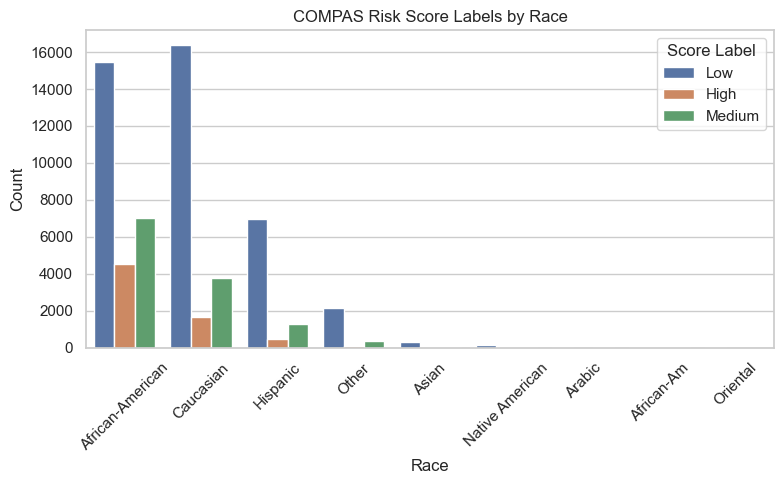

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="race", hue="score_label", order=df["race"].value_counts().index)
plt.title("COMPAS Risk Score Labels by Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.legend(title="Score Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/score_label_by_race.png")
plt.show()


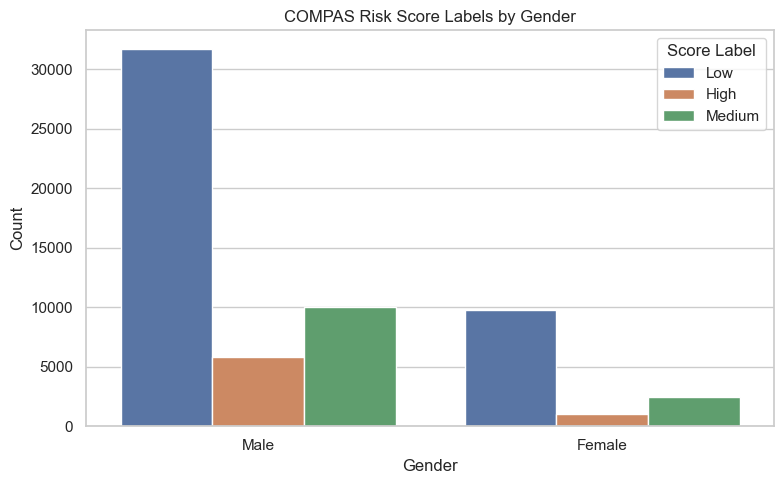

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sex", hue="score_label", order=df["sex"].value_counts().index)
plt.title("COMPAS Risk Score Labels by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Score Label")
plt.tight_layout()
plt.savefig("../outputs/score_label_by_gender.png")
plt.show()


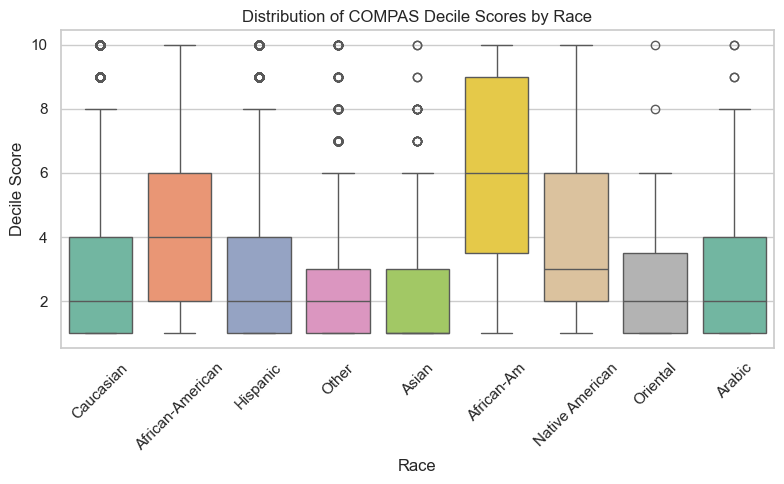

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="race", y="score", palette="Set2")
plt.title("Distribution of COMPAS Decile Scores by Race")
plt.xlabel("Race")
plt.ylabel("Decile Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/score_distribution_by_race.png")
plt.show()


In [20]:
# High risk = score 8, 9, 10 → 1; else → 0
df["high_risk"] = (df["score"] >= 8).astype(int)
df["high_risk"].value_counts()


high_risk
0    53975
1     6823
Name: count, dtype: int64

In [21]:
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference

# Audit for racial bias in high-risk predictions
metric_frame_race = MetricFrame(
    metrics=selection_rate,
    y_true=df["high_risk"],
    y_pred=df["high_risk"],
    sensitive_features=df["race"]
)

dp_diff_race = demographic_parity_difference(
    y_true=df["high_risk"],
    y_pred=df["high_risk"],
    sensitive_features=df["race"]
)

print("Selection Rate by Race:\n", metric_frame_race.by_group)
print(f"\nDemographic Parity Difference (Race): {dp_diff_race:.4f}")


Selection Rate by Race:
 race
African-Am          0.450980
African-American    0.168025
Arabic              0.066667
Asian               0.043210
Caucasian           0.075718
Hispanic            0.054162
Native American     0.146119
Oriental            0.051282
Other               0.034363
Name: selection_rate, dtype: float64

Demographic Parity Difference (Race): 0.4166


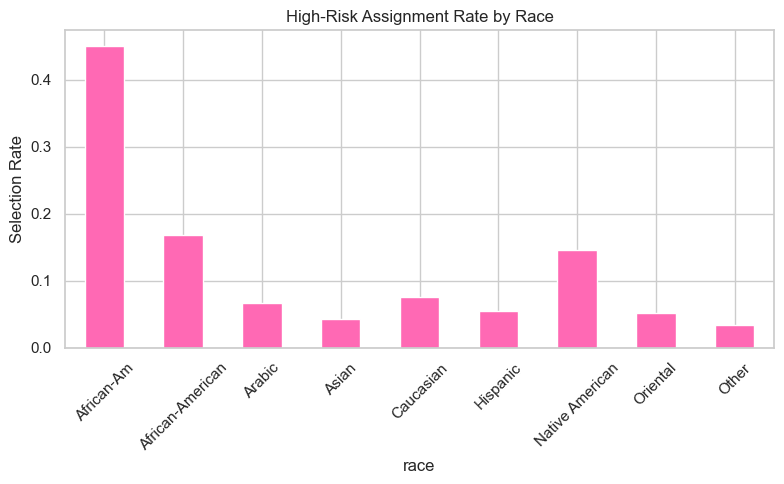

In [22]:
plt.figure(figsize=(8, 5))
metric_frame_race.by_group.plot(kind="bar", color="hotpink")
plt.title("High-Risk Assignment Rate by Race")
plt.ylabel("Selection Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/high_risk_by_race.png")
plt.show()


In [23]:
# Fairness audit by gender
metric_frame_sex = MetricFrame(
    metrics=selection_rate,
    y_true=df["high_risk"],
    y_pred=df["high_risk"],
    sensitive_features=df["sex"]
)

dp_diff_sex = demographic_parity_difference(
    y_true=df["high_risk"],
    y_pred=df["high_risk"],
    sensitive_features=df["sex"]
)

print("Selection Rate by Gender:\n", metric_frame_sex.by_group)
print(f"\nDemographic Parity Difference (Gender): {dp_diff_sex:.4f}")


Selection Rate by Gender:
 sex
Female    0.078084
Male      0.121801
Name: selection_rate, dtype: float64

Demographic Parity Difference (Gender): 0.0437


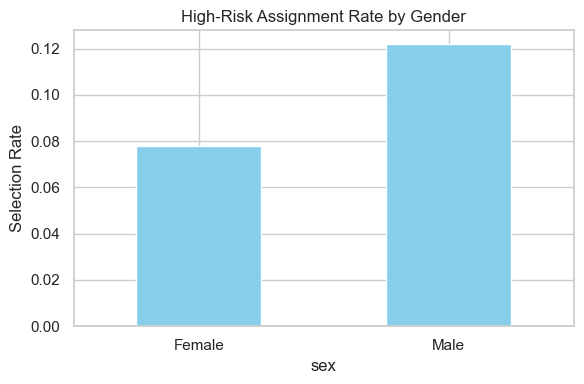

In [24]:
plt.figure(figsize=(6, 4))
metric_frame_sex.by_group.plot(kind="bar", color="skyblue")
plt.title("High-Risk Assignment Rate by Gender")
plt.ylabel("Selection Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../outputs/high_risk_by_gender.png")
plt.show()


In [25]:
summary = pd.DataFrame({
    "Group": metric_frame_race.by_group.index.tolist() + metric_frame_sex.by_group.index.tolist(),
    "Type": ["Race"] * len(metric_frame_race.by_group) + ["Gender"] * len(metric_frame_sex.by_group),
    "High-Risk Selection Rate": list(metric_frame_race.by_group) + list(metric_frame_sex.by_group)
})

summary.sort_values("High-Risk Selection Rate", ascending=False)


,Group,Type,High-Risk Selection Rate
0,African-Am,Race,0.450980
1,African-American,Race,0.168025
6,Native American,Race,0.146119
10,Male,Gender,0.121801
9,Female,Gender,0.078084
4,Caucasian,Race,0.075718
2,Arabic,Race,0.066667
5,Hispanic,Race,0.054162
7,Oriental,Race,0.051282
3,Asian,Race,0.043210
